In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import gudhi
from tqdm import tqdm
from numba import jit

In [2]:
def number_of_b0_b1(p):
    rips = gudhi.RipsComplex(points = p, max_edge_length = 1.5)
    s_tree = rips.create_simplex_tree(max_dimension = 2)
    diag = s_tree.persistence()
    b0, b1 = 0, 0
    for dg in diag:
        if(dg[1][1] > 1.42):
            if(dg[0] == 0):
                b0 += 1
            if(dg[0] == 1):
                b1 += 1
    return b0, b1, diag

In [3]:
@jit(forceobj=True)
def image_to_point(X):
    points = []
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if(X[i, j] != 255):
                a = np.array([i, j])
                points.append(a)
    points = np.array(points)
    return points

In [4]:
def local_merging_number(X, patches_x, patches_y, step_perc = 0.5, thresh = 1):
    x_b0, x_b1, dg = number_of_b0_b1(image_to_point(X))

    px_s = (int)(X.shape[0] / patches_x) 
    py_s = (int)(X.shape[1] / patches_y)
    while((X.shape[0] - patches_x * px_s) >= px_s):
      px_s += 1
    while((X.shape[1] - patches_y * py_s) >= py_s):
      py_s += 1
    print(f"{X.shape}, px_s = {px_s}, py_s = {py_s}")
    
    
    Y = np.zeros([X.shape[0], X.shape[1]]) + 255

    offset = 0
    
    lg = np.zeros([patches_x, patches_y])
    olg = np.zeros([patches_x, patches_y])

    step_x = (int)(step_perc * px_s)
    step_y = (int)(step_perc *py_s)
    i, j = 0, 0
    pbar = tqdm(total = X.shape[0] - px_s)
    while(i < (X.shape[0] - px_s)):
      while(j < (X.shape[1] - py_s)):
        X1 = np.zeros([X.shape[0], X.shape[1]]) + 255
        X2 = np.zeros([X.shape[0], X.shape[1]]) + 255
        # print(f"({i + 1} : {i + px_s}), ({j + 1} : {j + py_s}), {offset}")
        X1[ (i + 1) : (i + step_x), (j + 1) : (j + py_s) ] = np.array(X[(i + 1) : (i + step_x), (j + 1) : (j + py_s)])
        x1_b0, x1_b1, dg = number_of_b0_b1(image_to_point(X1[(i + 1) : (i + step_x), (j + 1) : (j + py_s)]))

        X2 = np.array(X)
        X2[ i : (i + px_s - 1), j : (j + py_s - 1)] = 255
        x2_b0, x2_b1, dg = number_of_b0_b1(image_to_point(X2))

        if((x1_b1 != 0) or (x2_b1 < x_b1)):
          n = (int) (i/px_s)
          m = (int) (j/py_s)
          olg[n, m] += (x1_b1 + x2_b1)
          Y[i : (i + px_s - 1), j : (j + py_s - 1) ] = np.array(X[i : (i + px_s - 1), j : (j + py_s - 1) ])
          cv2.imwrite(f"./images/croped/image_Y.png", Y)

        # cv2.imwrite(f"./images/croped/image_X1_{offset}.png", X1)
        # cv2.imwrite(f"./images/croped/image_X2_{offset}.png", X2)
        offset+=1
        j += step_y
      j = 0
      i += step_x
      pbar.update(step_x)
    pbar.close()
    return lg,olg, Y

In [5]:
img = cv2.imread('./images/qr-code-7.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [6]:
orig_map = plt.cm.get_cmap('Greys')
rev_map = orig_map.reversed()

In [7]:
img.shape

(928, 928)

In [8]:
# X = np.array(img[370:1530, 370:1230])
X = np.array(img)
X.shape

(928, 928)

In [9]:
X = cv2.resize(X, [(int)(X.shape[0]/6), (int)(X.shape[1]/6)])
X.shape

(154, 154)

In [10]:
ret,X_ = cv2.threshold(X,70,255,cv2.THRESH_BINARY)

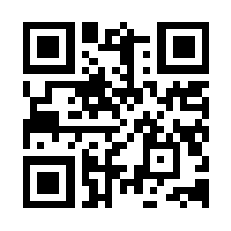

In [11]:
fig1, ax1 = plt.subplots()

ax1.axis('off')
ax1.imshow(X_, cmap=rev_map);

In [12]:
b0, b1, dg= number_of_b0_b1(image_to_point(X_))
b1

18

In [13]:
X_.shape

(154, 154)

In [14]:
lg_num, olg_num, heat_map = local_merging_number(X_, 12, 12, 0.3)

(154, 154), px_s = 12, py_s = 12


144it [16:47,  7.00s/it]                         


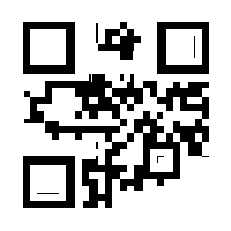

In [15]:
fig2, ax2 = plt.subplots()

ax2.axis('off')
ax2.imshow(heat_map, cmap=rev_map);

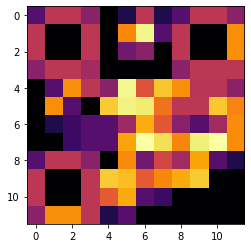

In [16]:
fig4, ax4 = plt.subplots()
ax4.imshow(olg_num, cmap = 'inferno');